In [5]:
import pandas as pd
import numpy as np
import string


In [2]:
products = pd.read_csv('amazon_baby.csv')

In [3]:
products.shape

(183531, 3)

In [7]:
def remove_punctuation(text):
    return text.translate(str.maketrans('','', string.punctuation)) 

products =  products.fillna({'review':''})
products['review_clean'] = products['review'].apply(remove_punctuation)

In [8]:
products = products[products['rating'] != 3]

In [9]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [11]:
train_idx = pd.read_json('module-9-assignment-train-idx.json')
test_idx = pd.read_json('module-9-assignment-test-idx.json')

In [12]:
train_data = products.iloc[train_idx[0]]
test_data = products.iloc[test_idx[0]]

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [22]:
from sklearn.linear_model import LogisticRegression

In [25]:
logreg=LogisticRegression()

In [26]:
model = logreg.fit(train_matrix,train_data['sentiment'])

/home/malav/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'].to_numpy(), y_pred=model.predict(test_matrix))
print( "Test Accuracy: %s" % accuracy)

Test Accuracy: 0.9325953923686106


In [28]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print( "Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


In [30]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print( '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3784
     -1       |        1        |  1457
      1       |       -1        |   790
      1       |        1        | 27305


In [51]:
cmat

array([[ 3784,  1457],
       [  790, 27305]])

In [49]:
print("Cost:",(100*cmat[0,1]+1*cmat[1,0]))

Cost: 146490


In [50]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=model.predict(test_matrix))
print( "Precision on test data: %s" % precision)

Precision on test data: 0.9493428829705862


In [53]:
print(cmat[0,1]/(cmat[1,1]+cmat[0,1]))

0.05065711702941381


In [54]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=model.predict(test_matrix))
print ("Recall on test data: %s" % recall)

Recall on test data: 0.9718811176365901


In [83]:
def apply_threshold(probabilities,thresold):
    a = []
    for i in probabilities:
        if i>=thresold:
            a.append(+1)
        else:
            a.append(-1)
    return a

In [84]:
probabilities = model.predict_proba(test_matrix)[:,1]

In [85]:
probabilities

array([0.92578352, 0.99999953, 0.9358188 , ..., 0.99996506, 0.99997914,
       0.9869782 ])

In [89]:
threshold_values = np.linspace(0.5, 1, num=100)
print( threshold_values)

[0.5        0.50505051 0.51010101 0.51515152 0.52020202 0.52525253
 0.53030303 0.53535354 0.54040404 0.54545455 0.55050505 0.55555556
 0.56060606 0.56565657 0.57070707 0.57575758 0.58080808 0.58585859
 0.59090909 0.5959596  0.6010101  0.60606061 0.61111111 0.61616162
 0.62121212 0.62626263 0.63131313 0.63636364 0.64141414 0.64646465
 0.65151515 0.65656566 0.66161616 0.66666667 0.67171717 0.67676768
 0.68181818 0.68686869 0.69191919 0.6969697  0.7020202  0.70707071
 0.71212121 0.71717172 0.72222222 0.72727273 0.73232323 0.73737374
 0.74242424 0.74747475 0.75252525 0.75757576 0.76262626 0.76767677
 0.77272727 0.77777778 0.78282828 0.78787879 0.79292929 0.7979798
 0.8030303  0.80808081 0.81313131 0.81818182 0.82323232 0.82828283
 0.83333333 0.83838384 0.84343434 0.84848485 0.85353535 0.85858586
 0.86363636 0.86868687 0.87373737 0.87878788 0.88383838 0.88888889
 0.89393939 0.8989899  0.9040404  0.90909091 0.91414141 0.91919192
 0.92424242 0.92929293 0.93434343 0.93939394 0.94444444 0.94949

In [91]:
precision_all = []
recall_all = []

for i in threshold_values:
    precision_all.append(precision_score(y_true=test_data['sentiment'].to_numpy(),y_pred=apply_threshold(probabilities,i)))
    recall_all.append(recall_score(y_true=test_data['sentiment'].to_numpy(),y_pred=apply_threshold(probabilities,i)))
    

In [96]:
import matplotlib.pyplot as plt
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

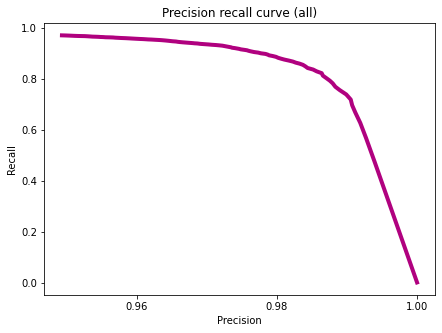

In [97]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [103]:
test_data =  test_data.fillna({'name':''})

In [104]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

In [106]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

In [108]:
precision_all = []
recall_all = []

for i in threshold_values:
    precision_all.append(precision_score(y_true=baby_reviews['sentiment'].to_numpy(),y_pred=apply_threshold(probabilities,i)))
    recall_all.append(recall_score(y_true=baby_reviews['sentiment'].to_numpy(),y_pred=apply_threshold(probabilities,i)))
    

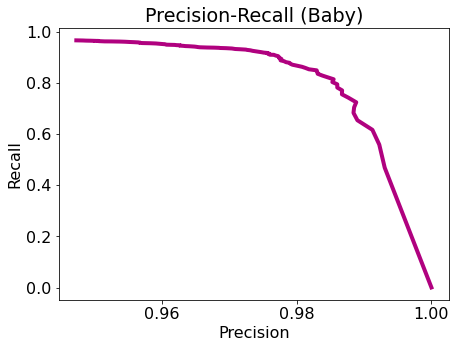

In [109]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")